# Car Pooling Algorithm Analysis

In [1]:
from pandas import reset_option
import matplotlib.pyplot as plt
import random
import requests
import copy
import math

### General Setup

In [3]:
class node:
    def __init__(self, id, type, flag, lat, long):
        self.id = id
        self.type = type # 0: car, 1: start, 2:end
        self.isAccessible = flag
        self.lat = lat
        self.long = long

In [4]:
class edge:
    def __init__(self, id, startNodeId, endNodeId, distance, polyLine, duration):
        self.id = id
        self.startNodeId = startNodeId # start point of an edge
        self.endNodeId = endNodeId # end point of an edge
        self.distance = distance # distance between two points
        self.polyLine = polyLine # google polyline encripted value for this path
        self.duration = duration

In [5]:
# Graph Class
class graph:
    def __init__(self):
        self.adjList = [[]] # list of edges
        self.nodes = [] # list of nodes
        self.nodeCounter = 0 # points to the next free node id
        self.edgeCounter = 0 # points to the next free edge id 
    
    def getNodeFromId(self, nodeId):
        for n in self.nodes:
            if n.id == nodeId:
                return n
    
    def getEdgeFromEdgeNodes(self, node1, node2):
        for e in self.adjList[node1]: # loops over all the edges related to the start node
            if e.endNodeId == node2: # if the edge is equal to the end node return it
                return e
        return -1 # -1 means there is no edge between the two entered nodes 
    
    def addNode(self, type, flag, lat, long):
        self.nodes.append(node(self.nodeCounter, type, flag, lat, long))
        self.nodeCounter += 1
        self.adjList.append([])
    
    def addEdge(self, startNode, endNode, weight, polyline, duration):
        self.adjList[startNode].append(edge(self.edgeCounter, startNode, endNode, weight, polyline, duration))
        self.edgeCounter += 1
    
    def calcEdgeWeight(self, startNode, endNode):
        s = self.getNodeFromId(startNode) # getting the start and end nodes 
        e = self.getNodeFromId(endNode)

        r = requests.get('http://127.0.0.1:5000/route/v1/driving/'+ str(s.long) +','+ str(s.lat) +';'+ str(e.long) +','+ str(e.lat) +'?steps=false') # makes a request using the pos of the start and end nodes
        data = r.json() # converts the json data to a readable format

        return data['routes'][0]['distance'], data['routes'][0]['geometry'], data['routes'][0]['duration'] # returns the distance to be used as the weight of an edge and the polyline
    
    def addCar(self, loc):
        self.addNode(0, False, loc[1], loc[0]) # car always has a type value of 0

        for node in self.nodes:
            if node.type == 1: # add a connection from the new car to all the starting nodes 
                w, l = self.calcEdgeWeight(self.nodeCounter-1, node.id)
                self.addEdge(self.nodeCounter-1, node.id, w, l)

    def addTrip(self, start, end):
        self.addNode(1, True, start[1], start[0]) # add the start node of a trip
        self.addNode(2, False, end[1], end[0]) # add the end node of a trip

        for node in self.nodes:
            if node.id != self.nodeCounter-1 and node.id != self.nodeCounter-2: # add an edge from every node to the new start and end nodes 
                w, l, d = self.calcEdgeWeight(node.id, self.nodeCounter-2)
                self.addEdge(node.id, self.nodeCounter-2, w, l, d)
                if node.type != 0: # if not a car
                    w, l, d = self.calcEdgeWeight(node.id, self.nodeCounter-1)
                    self.addEdge(node.id, self.nodeCounter-1, w, l, d) # add an edge from every node to the new end node (execpt form cars)

            if node.type != 0 and node.id != self.nodeCounter-2: # add an edge from the new start node to all the other start and end nodes
                w, l, d = self.calcEdgeWeight(self.nodeCounter-2, node.id)
                self.addEdge(self.nodeCounter-2, node.id, w, l, d)

            if node.type != 0 and node.id != self.nodeCounter-1 and node.id != self.nodeCounter-2: # add an edge from the new end node to all the other end and start nodes
                w, l, d = self.calcEdgeWeight(self.nodeCounter-1, node.id)
                self.addEdge(self.nodeCounter-1, node.id, w, l, d)
    
    # Functions for testing 

    def printAdjList(self):
        for x in range(0, len(self.adjList)):
            print(x, ": ", end =" ")
            for y in self.adjList[x]:
                print(y.endNodeId, end =" ")
            print("")


#### General Methods

In [6]:
def checkSolution(solution, graph):
    correct = True
    # loop over the whole solution and check if it is possible to get from one node to the next. If it is solution is valid
    for n in range(1, len(solution)): 
        n1 = solution[n]
        n2 = solution[n-1]
        edge = graph.getEdgeFromEdgeNodes(n2, n1) # returns -1 if there is no edge

        if edge == -1:
            return False # the solution is not valid 

        if graph.getNodeFromId(n1).type == 2: # if the point is an end point 
            start = n1 -1
            for x in solution[:n]: # check if its start point is in the list before it
                if x == start:
                    correct = True
                    break
                else:
                    correct = False

        if not correct:
            return False

    return True

In [7]:
def fitnessFuncDistance(solutions, graph):
    value = 0
    for solution in solutions:
        for n in range(1, len(solution)):
            n1 = solution[n]
            n2 = solution[n-1]
            value += graph.getEdgeFromEdgeNodes(n2, n1).distance # adds up the weight of all the edges in the path
    
    return value

In [8]:
def fitnessFuncDuration(solutions, graph):
    value = 0
    startNodes = []
    for solution in solutions:
        for n in range(1, len(solution)):
            if graph.getNodeFromId(n).type == 1:
                startNodes.append(n)
    
    for solution in solutions:
        duration = 0
        for n in range(1, len(solution)):
            n1 = solution[n]
            n2 = solution[n-1]
            duration += graph.getEdgeFromEdgeNodes(n2, n1).duration

            if n in startNodes:
                value += duration**2
    
    value =  math.sqrt(value)
    
    return value

In [9]:
def fitnessFuncComposite(solutions, graph):
    distImp = 0.5
    durImp = 0.5

    value = 0
    for solution in solutions:
        for n in range(1, len(solution)):
            n1 = solution[n]
            n2 = solution[n-1]
            value += graph.getEdgeFromEdgeNodes(n2, n1).duration # adds up the weight of all the edges in the path

    return (value*distImp) + (fitnessFuncDuration(solutions, graph)*durImp)


#### Tabu Search

In [10]:
carSize = 3
def initSolution(graph): # used to randomly generate a solution 
    solutions = []
    visited = [False] * len(graph.nodes) # will indicate if a node has been visited yet
    
    nodePointer = 0


    for n in graph.nodes:
        solution = []
        if n.type == 0: # finds a car as the starting point
            solution.append(n.id)
            visited[n.id] = True
            s = 0
            while s < carSize and s < (len(graph.nodes)/2)-1:
                if graph.getNodeFromId(nodePointer).type != 0:
                    solution.append(nodePointer)
                    solution.append(nodePointer + 1)

                    nodePointer += 2
                    s += 1
                else:
                    nodePointer += 1

            solutions.append(solution)

    return solutions

In [11]:
def neighborhood(solutions, graph): # returns all the possible swaps for a given solution 
    neighborhood = []
    neighborhood2 = []

    for s in range(len(solutions)):
        for x in range(1, len(solutions[s])):
            for y in range(x + 1, len(solutions[s])):
                newSolution = copy.deepcopy(solutions)
                newSolution[s][x], newSolution[s][y] = newSolution[s][y], newSolution[s][x] # swap 2 values 
                if checkSolution(newSolution[s], graph) == True: # check if swap is valid
                    neighborhood.append(newSolution) # if swap is good add it to the list 
        
    for s in range(len(solutions)):
        for pos in range(1, len(solutions[s])):
            if graph.getNodeFromId(solutions[s][pos]).type == 1:
                start = pos
                end = solutions[s].index(graph.getNodeFromId(solutions[s][pos]+1).id)

                for sol in range(s+1, len(solutions)):
                    for index in range(1, len(solutions[s])):
                        if graph.getNodeFromId(solutions[sol][index]).type == 1:
                            newSolution = copy.deepcopy(solutions)
                            temp1, temp2 = newSolution[s][start], newSolution[s][end]
                            newSolution[s][start], newSolution[s][end] = newSolution[sol][index], newSolution[sol][solutions[sol].index(graph.getNodeFromId(solutions[sol][index]+1).id)]
                            newSolution[sol][index], newSolution[sol][solutions[sol].index(graph.getNodeFromId(solutions[sol][index]+1).id)] = temp1, temp2
                            neighborhood2.append(newSolution)


    
    return neighborhood, neighborhood2

In [12]:
def tabuSearch(graph, iterations, tabuSize, s, fitnessFunc):
    counts = []
    bestSolution = s
    solution = bestSolution
    tabuList = list()
    tabuList2 = list()
    bestCost = fitnessFunc(bestSolution, graph)
    counter = 1

    while counter <= iterations:
        neighbours, neighbours2 = neighborhood(solution, graph)
        # print(neighbours)
        found = False # indicates we found a set of different nodes that are not in the tabu list 
        currentBestSolutionIndex = 0
        currentBestSolution = neighbours[currentBestSolutionIndex]

        while not found and currentBestSolutionIndex < len(neighbours) - 1:
            i = 0
            breaks = False
            while i < len(currentBestSolution):
                j = 0
                while j < len(currentBestSolution[i]):
                    if currentBestSolution[i][j] != solution[i][j]: # if the same node position is not equal 
                        firstNode = currentBestSolution[i][j]
                        secondNode = solution[i][j]
                        breaks = True
                        break
                    j += 1
                    if breaks:
                        break
                i += 1

            if [firstNode, secondNode] not in tabuList and [secondNode, firstNode] not in tabuList: # check if the swap is in the tabu list or not 
                tabuList.append([firstNode, secondNode]) # add the set to the tabuList
                found = True 

                solution = currentBestSolution
                cost = fitnessFunc(currentBestSolution, graph)

                if cost < bestCost: # checks if the new solution is better than the current best 
                    bestCost = cost
                    bestSolution = solution
            
            else:
                currentBestSolutionIndex += 1 # if nothing was found in with the current swap, go the the next one 
                currentBestSolution = neighbours[currentBestSolutionIndex]
        
        if len(tabuList) >= tabuSize:
            tabuList.pop(0) # removes the oldest element in the list

        counter = counter + 1

        if len(neighbours2) > 0:
            found = False
            size = 0
            nextSoluiton = neighbours2[size]

            while not found and size < len(neighbours2) - 1:
                i = 0
                breaks = False
                while i < len(nextSoluiton): 
                    j = 0
                    pointsFound = 0
                    while j < len(nextSoluiton[i]):
                        if nextSoluiton[i][j] != solution[i][j]:
                            if pointsFound == 0:
                                start1 = nextSoluiton[i][j]
                                start2 = solution[i][j]
                                pointsFound += 1
                            else:
                                end1 = nextSoluiton[i][j]
                                end2 = solution[i][j]
                                breaks = True
                                break
                        j += 1
                    if breaks == True:
                        break
                    i += 1

                if [[start1, end1], [start2, end2]] not in tabuList2 and [[start2, end2], [start1, end1]] not in tabuList2:
                    tabuList2.append([[start1, end1], [start2, end2]])
                    found = True 

                    solution = nextSoluiton
                    cost = fitnessFunc(solution, graph)

                    if cost < bestCost: # checks if the new solution is better than the current best 
                        bestCost = cost
                        bestSolution = solution
                else:
                    size += 1 # if nothing was found in with the current swap, go the the next one 
                    nextSoluiton = neighbours2[size]

                if len(tabuList2) >= tabuSize:
                    tabuList2.pop(0) # removes the oldest element in the list
        counts.append(bestCost)
    
    return bestSolution, bestCost, counts

#### Genetic Algorithms

In [13]:
class geneticAlgorithm:
    def __init__(self, graph, ps, fitnessFunc):
        self.graph = graph
        self.populationSize = ps
        self.population = []
        self.fitness = []
        self.normFitness = [999] * ps # normalized values
        self.fitnessFunc = fitnessFunc

        self.initPopulation()
        self.normalizeFitness()
    
    def initPopulation(self):
        for x in range(self.populationSize):
            self.population.append(initSolution(self.graph))
            self.fitness.append(self.fitnessFunc(self.population[x], self.graph))
    
    def normalizeFitness(self): #sets all the weights values to be between 0 and 1
        total = 0
        for i in range(self.populationSize):
            total += self.fitness[i]

        for i in range(self.populationSize):
            self.normFitness[i] = self.fitness[i]/total
    
    def pickSolution(self):
        index = 0
        r = random.uniform(0, 1)

        while r > 0: # loops randomly picking form the top solutions
            r = r - self.normFitness[index]
            index += 1
        
        return self.population[index-1]
    
    def swap(self, solution):
        swapped = False
        while not swapped:
            rand = bool(random.getrandbits(1)) # this value decides if we will swap in the same car, or swap cars. 
            if rand: # same car
                sol = random.randint(1, len(solution)-1)
                n1 = random.randint(1, len(solution[sol])-1)
                n2 = random.randint(1, len(solution[sol])-1)

                newSolution = copy.deepcopy(solution)
                newSolution[sol][n1], newSolution[sol][n2] = newSolution[sol][n2], newSolution[sol][n1] # swap 2 values
                swapped = checkSolution(newSolution[sol], self.graph)
            else: # different cars
                sol = random.randint(0, len(solution)-1)
                for x in range(1, len(solution[sol])-1): # find trip in first car
                    if self.graph.getNodeFromId(solution[sol][x]).type == 1:
                        start1 = x
                        end1 = solution[sol].index(self.graph.getNodeFromId(solution[sol][x]+1).id)
                
                sol2 = random.randint(0, len(solution)-1)
                while sol2 == sol:
                    sol2 = random.randint(0, len(solution)-1)

                for y in range(1, len(solution[sol2])-1): # find trip in second car
                    if self.graph.getNodeFromId(solution[sol2][y]).type == 1:
                        start2 = y
                        end2 = solution[sol2].index(self.graph.getNodeFromId(solution[sol2][y]+1).id)

                newSolution = copy.deepcopy(solution)
                temp1, temp2 = newSolution[sol][start1], newSolution[sol][end1]
                newSolution[sol][start1], newSolution[sol][end1] = newSolution[sol2][start2], newSolution[sol2][end2] # swap the trips
                newSolution[sol2][start2], newSolution[sol2][end2] = temp1, temp2
                swapped = True
                
        return newSolution
    
    def mutateSolution(self, solution, mutationFactor):
        newSolution = self.swap(solution)
        return newSolution
    
    def findBestSolution(self): # returns the best solution in a population
        bestSolution = self.population[0]
        bestCost = self.fitness[0]
        for i in range(1, self.populationSize):
            if self.fitness[i] < bestCost:
                bestCost = self.fitness[i]
                bestSolution = self.population[i]
        
        return bestSolution, bestCost
        
    
    def geneticAlgorithm(self, iterations):
        costs = []
        bestSolution, bestCost = self.findBestSolution()
        costs.append(bestCost)
        for iter in range(1, iterations): # loop for specified amount 
            newPopultion = []
            newFitness = []
            for s in range(self.populationSize): # create the next generation
                newPopultion.append(self.mutateSolution(self.pickSolution(), 1))
                newFitness.append(self.fitnessFunc(newPopultion[s], self.graph))
            self.population = newPopultion
            self.fitness = newFitness
            self.normalizeFitness()

            popBestSolution, popBestCost = self.findBestSolution()
            if popBestCost < bestCost: # if new best is found
                bestSolution = popBestSolution
                bestCost = popBestCost
            costs.append(bestCost)
        
        return bestSolution, bestCost, costs

### Testing

In [14]:
network = graph()
# enter coords as long, lat
network.addCar([14.513809277460041, 35.89897453256716]) # valletta
network.addCar([14.349747452527506, 35.952589620545496]) # Mellieha

network.addTrip([14.423235598020154, 35.91419450996914], [14.407218690503381, 35.888194056331706]) # Mosta to mdina
network.addTrip([14.49291350433241, 35.87369410066685], [14.513809277460041, 35.89897453256716]) # Marsa to Valletta
network.addTrip([14.349747452527506, 35.952589620545496], [14.488425821564382, 35.88613649037252])  # Mellieha to Hamrun

network.addTrip([14.396021566820055, 35.93589926856759], [14.407218690503381, 35.888194056331706]) # st pauls bay to mdina
network.addTrip([14.513809277460041, 35.89897453256716], [14.396021566820055, 35.93589926856759]) # Valletta to st pauls bay
network.addTrip([14.469391291395608,35.87691014067125], [14.488425821564382, 35.88613649037252])  # qormi to Hamrun

In [15]:
network2 = graph()

network2.addCar([14.381200578207975, 35.96174457330435])   # Selmun
network2.addCar([14.396564271819427, 35.93596619845886])   # St Pauls Bay
network2.addCar([14.361974506556155, 35.91942469964549])   # Mgarr
network2.addCar([14.40652063325507, 35.888417448220515])   # Mdina
network2.addCar([14.38532045332923, 35.86289340290897])    # Had-Dingli
network2.addCar([14.438792970654086, 35.876734437130544])  # Haz-Zebbug
network2.addCar([14.454156663043637, 35.895301272593])     # Balzan
network2.addCar([14.493810440887742, 35.893632521550096])  # Pieta
network2.addCar([14.511148240026317, 35.86741460941653])   # Tarxien
network2.addCar([14.492866305085785, 35.836108659428106])  # Hal Safi
    
network2.addTrip([14.423235598020154, 35.91419450996914], [14.407218690503381, 35.888194056331706])   # Mosta to mdina
network2.addTrip([14.545566346261706, 35.87283971673811], [14.535609986947806, 35.85454588170675])    # Haz-Zabbar to zejtun
network2.addTrip([14.495355394293833, 35.90566064778522], [14.487029817971004, 35.89599657516383])    # Gzira to Msida
network2.addTrip([14.466087130603144, 35.895301272651956], [14.419738560123472, 35.89057305350045])   # Birkirkara to Attard
network2.addTrip([14.49291350433241, 35.87369410066685], [14.513809277460041, 35.89897453256716])     # Marsa to Valletta
network2.addTrip([14.430639056958517, 35.93221338788409], [14.475099351136112, 35.928946908622805])   # Naxxar to Pembroke
network2.addTrip([14.349747452527506, 35.952589620545496], [14.488425821564382, 35.88613649037252])   # Mellieha to Hamrun
network2.addTrip([14.452157373873439, 35.909293992478155], [14.439899447417208, 35.89882472107257])   # Iklin to Lija
network2.addTrip([14.470057608789288, 35.919017557794774], [14.49148169541245, 35.922851227239875])   # Sqieqi to Paceville
network2.addTrip([14.475099351136112, 35.928946908622805], [14.495355394293833, 35.90566064778522])   # Pembroke to Gzira
network2.addTrip([14.396021566820055, 35.93589926856759], [14.407218690503381, 35.888194056331706])   # St Pauls bay to Mdina
network2.addTrip([14.498520687544623, 35.913751455350116], [14.485762437559565, 35.90828089771133])   # Sliema to Kappara
network2.addTrip([14.488811272099182, 35.91292262373294], [14.470057609526041, 35.84402708219966])    # Saint Julians to Mqabba
network2.addTrip([14.513809277460041, 35.89897453256716], [14.396021566820055, 35.93589926856759])    # Valletta to St Pauls bay
network2.addTrip([14.53180611175649, 35.89131402793584], [14.454060341546587, 35.83288089148569])     # Kalkara Qrendi
network2.addTrip([14.534537227691992, 35.85846298643352], [14.54109190567531, 35.890133986928])       # Zejtun to Smart City
network2.addTrip([14.469391291395608,35.87691014067125], [14.488425821564382, 35.88613649037252])     # Qormi to Hamrun
network2.addTrip([14.483531114746006, 35.841025986602226], [14.480557233033442, 35.82193439301399])   # Kirkop to zurrieq
network2.addTrip([14.554493402284638, 35.86057243985436], [14.43664734447984, 35.93252407235249])     # Marsaskala to naxxar
network2.addTrip([14.432798599308622, 35.846482945229674], [14.480448112126183, 35.8215269171298])    # Siggiewi to Zurrieq
network2.addTrip([14.503166650376741, 35.847493884379865], [14.538528892077835, 35.84081464096383])   # Gudja to Marsaxlokk
network2.addTrip([14.502480004433215, 35.91098815347837], [14.351417332252417, 35.952782156260305])   # Sliema Mellieha
network2.addTrip([14.480448112126183, 35.8215269171298], [14.432798599308622, 35.846482945229674])    # Zurrieq to siggiewi
network2.addTrip([14.475443339054953, 35.90792935616374], [14.509775612551161, 35.88248114168623])    # San Gwann to paola
network2.addTrip([14.430381563595416, 35.84661492276736], [14.420425204281518, 35.89050351825068])    # Siggiewi to Attard
network2.addTrip([14.349747452527506, 35.952589620545496], [14.510671636760655, 35.88200443585789])   # Mellieha to Paola
network2.addTrip([14.505998399035033, 35.85600676106393], [14.49243715100403, 35.87374386499355])     # Santa Lucija to Marsa
network2.addTrip([14.429694917902895, 35.91775645709981], [14.457761551486044, 35.90976230777559])    # Mosta to Iklin
network2.addTrip([14.411584641554525, 35.948404792667816], [14.3615453529338, 35.91866009299031])     # Buggibba to Mgarr
network2.addTrip([14.351417332252417, 35.952782156260305], [14.3615453529338, 35.91866009299031])     # Mellieha to Mgarr
#network2.addTrip([14.475700165922293, 35.890016773865945], [14.486257340022377, 35.895857515103536])  # Santa Venera to Msida

In [14]:
solutions = initSolution(network)

bestSolution, bestCost, counts = tabuSearch(network, 1000, 30, solutions, fitnessFuncComposite)
print("Start solution: ", solutions, " Cost: ", fitnessFuncDistance(solutions, network))
print("End solution: ", bestSolution, " Cost: ", bestCost)

Start solution:  [[0, 2, 3, 4, 5, 6, 7], [1, 8, 9, 10, 11, 12, 13]]  Cost:  131389.80000000002
End solution:  [[0, 10, 11, 2, 8, 3, 9], [1, 6, 7, 12, 13, 4, 5]]  Cost:  4744.356517475297


In [15]:
g = geneticAlgorithm(network, 100, fitnessFuncComposite)

s, c, costs = g.geneticAlgorithm(1000)

print("End solution: ", s, " Cost: ", c)

End solution:  [[0, 2, 3, 4, 5, 10, 11], [1, 6, 8, 9, 12, 13, 7]]  Cost:  4939.730173945609


#### Changing tabu list size with a constant iterations

In [27]:
def tabuTest1(graph, iterations, fitnessFuc):
    solutions = initSolution(graph)
    eps = []
    for ep in range(1, iterations + 1):
        eps.append(ep)

    for s in range(20, 101, 20): #loop 5 times with values 20, 40, 60, 80, 100
            bestSolution, bestCost, counts = tabuSearch(graph, iterations, s, solutions, fitnessFuc) # run tabu search
            plt.plot(eps, counts, label=("Tabu Size: " + str(s)))
    
    plt.ylim(min(counts)-(0.05*min(counts)), max(counts)+(0.05*max(counts))) # set the y lims to the min and max plus a bit
    plt.ylabel('cost')
    plt.xlabel('episodes')
    plt.title('Change in cost over episodes')
    plt.legend(loc="upper right")

20
40
60
80
100


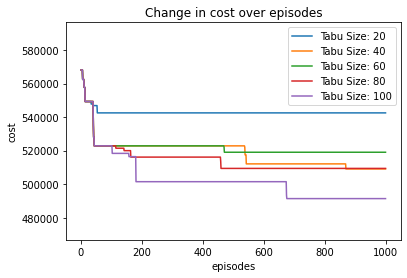

In [28]:
iterations = 1000
tabuTest1(network2, iterations, fitnessFuncDistance)

#### Changing number of iterations with constant tabu size

In [19]:
def tabuTest2(graph, tabuSize, fitnessFuc, solutions):
    for loop in range(100, 1001, 100):
        eps = []
        bestSolution, bestCost, counts = tabuSearch(graph, loop, tabuSize, solutions, fitnessFuc)

        for iter in range(0, loop):
            eps.append(iter)

        plt.plot(eps, counts, label=("Iterations: " + str(loop)), alpha=0.5)
    
    plt.ylim(min(counts)-(0.05*min(counts)), max(counts)+(0.05*max(counts)))
    plt.ylabel('cost')
    plt.xlabel('episodes')
    plt.title('Change in cost over episodes')
    plt.legend(loc="upper right")


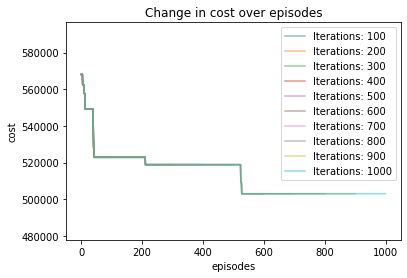

In [20]:
tabuSize = 50
sol = initSolution(network2)
tabuTest2(network2, tabuSize, fitnessFuncDistance, sol)

#### Changing population size, with constant iterations

In [29]:
def geneticTest1(graph, iterations, fitnessFuc):
    eps = []
    ymax = 0
    ymin = 1000000000

    for ep in range(1, iterations + 1):
        eps.append(ep)

    for s in range(20, 201, 20):
        g = geneticAlgorithm(graph, s, fitnessFuc)
        bestSolution, bestCost, counts = g.geneticAlgorithm(iterations)
        plt.plot(eps, counts, label=("Population Size: " + str(s)), alpha=0.8)
    
        if(min(counts) < ymin): ymin = min(counts)
        if(max(counts) > ymax): ymax = max(counts)
    
    plt.ylim(ymin-(0.05*ymin), ymax+(0.05*ymax))
    plt.ylabel('cost')
    plt.xlabel('episodes')
    plt.title('Change in cost over episodes')
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    

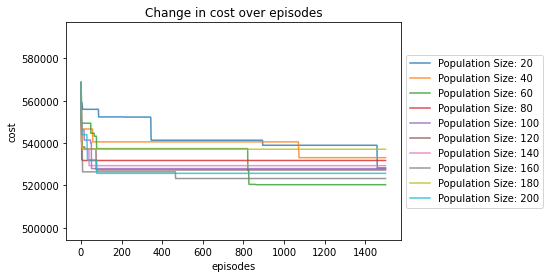

In [30]:
iterations = 1500
geneticTest1(network2, iterations, fitnessFuncDistance)  

#### Changing number of iterations, with constant population size

In [79]:
def geneticTest2(graph, population, fitnessFuc):
    g = geneticAlgorithm(graph, population, fitnessFuc)
    ymax = 0
    ymin = 1000000000
    for loop in range(100, 501, 100):
        eps = []
        bestSolution, bestCost, counts = g.geneticAlgorithm(loop)

        for iter in range(0, loop):
            eps.append(iter)

        plt.plot(eps, counts, label=("Iterations: " + str(loop)))

        if(min(counts) < ymin): ymin = min(counts)
        if(max(counts) > ymax): ymax = max(counts)
    
    plt.ylim(ymin-(0.05*ymin), ymax+(0.05*ymax))
    plt.ylabel('cost')
    plt.xlabel('episodes')
    plt.title('Change in cost over episodes')
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

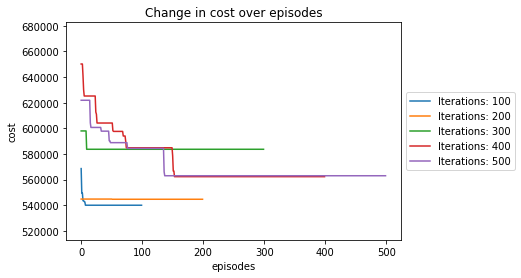

In [80]:
popSize = 100
geneticTest2(network2, popSize, fitnessFuncDistance)  

#### How best solution changes with different fit functions

In [24]:
solutions = initSolution(network)
print("Tabu Search\n")

print("Distance fitness function")
bestSolution, bestCost, counts = tabuSearch(network, 100, 30, solutions, fitnessFuncDistance)
print("Start solution: ", solutions, " Cost: ", fitnessFuncDistance(solutions, network))
print("End solution: ", bestSolution, " Cost: ", bestCost)

print()

print("Wait time fitness function")
bestSolution, bestCost, counts = tabuSearch(network, 100, 30, solutions, fitnessFuncDuration)
print("Start solution: ", solutions, " Cost: ", fitnessFuncDuration(solutions, network))
print("End solution: ", bestSolution, " Cost: ", bestCost)

print()

print("Composite function")
bestSolution, bestCost, counts = tabuSearch(network, 100, 30, solutions, fitnessFuncComposite)
print("Start solution: ", solutions, " Cost: ", fitnessFuncComposite(solutions, network))
print("End solution: ", bestSolution, " Cost: ", bestCost)



Tabu Search

Distance fitness function
Start solution:  [[0, 2, 3, 4, 5, 6, 7], [1, 8, 9, 10, 11, 12, 13]]  Cost:  131389.80000000002
End solution:  [[0, 10, 11, 2, 8, 3, 9], [1, 6, 7, 12, 13, 4, 5]]  Cost:  65331.0

Wait time fitness function
Start solution:  [[0, 2, 3, 4, 5, 6, 7], [1, 8, 9, 10, 11, 12, 13]]  Cost:  7637.658209163329
End solution:  [[0, 10, 11, 2, 8, 3, 9], [1, 6, 7, 12, 13, 4, 5]]  Cost:  4624.113034950595

Composite function
Start solution:  [[0, 2, 3, 4, 5, 6, 7], [1, 8, 9, 10, 11, 12, 13]]  Cost:  8384.829104581664
End solution:  [[0, 10, 11, 2, 8, 3, 9], [1, 6, 7, 12, 13, 4, 5]]  Cost:  4744.356517475297


In [25]:
print("Genetic Algorithm\n")


print("Distance fitness function")
g = geneticAlgorithm(network, 100, fitnessFuncDistance)
s, c, costs = g.geneticAlgorithm(1000)
print("End solution: ", s, " Cost: ", c)

print()

print("Wait time fitness function")
g = geneticAlgorithm(network, 100, fitnessFuncDuration)
s, c, costs = g.geneticAlgorithm(1000)
print("End solution: ", s, " Cost: ", c)

print()

print("Composite function")
g = geneticAlgorithm(network, 100, fitnessFuncComposite)
s, c, costs = g.geneticAlgorithm(1000)
print("End solution: ", s, " Cost: ", c)

Genetic Algorithm

Distance fitness function
End solution:  [[0, 2, 3, 4, 5, 10, 11], [1, 6, 8, 9, 12, 13, 7]]  Cost:  73127.4

Wait time fitness function
End solution:  [[0, 2, 3, 4, 5, 10, 11], [1, 6, 8, 9, 12, 13, 7]]  Cost:  4752.060347891218

Composite function
End solution:  [[0, 2, 3, 4, 5, 10, 11], [1, 6, 8, 9, 12, 7, 13]]  Cost:  4939.730173945609


### Optimization genetic algorithm

In [26]:
class optimizationGeneticAlgorithm:
    def __init__(self, graph, popsize):
        self.distWeight = 0.5 # current weight for distance
        self.durWeight = 0.5 # current weight for duration
        self.GlobalDistWeight = 0.5 # best weight for distance
        self.GlobalDurWeight = 0.5 # best weight for duration
        self.bestTime = math.inf # set to infinity 
        self.population = [] # current population
        self.populationFitness = [] 
        self.normalizePopFitness = []
        self.network = graph # the set of trips to be worked on

        self.initPopulation(popsize)
    
    def initPopulation(self, popsize):
        for x in range(0, popsize):
            rand = random.random()
            self.population.append([rand,1-rand])
    
    def testFitnessFunction(self, solutions, net):
        value = 0
        for solution in solutions:
            for n in range(1, len(solution)):
                n1 = solution[n]
                n2 = solution[n-1]
                value += net.getEdgeFromEdgeNodes(n2, n1).duration # adds up the weight of all the edges in the path

        return ((value*self.distWeight) + (fitnessFuncDuration(solutions, self.network)*self.durWeight))
    
    def calcFitness(self, optTime, solution):
        avWaitTime = 0
        numOfStartPoints = 0
        for sol in solution:
            curTime = 0
            for x in range(1, len(sol)):
                curTime += self.network.getEdgeFromEdgeNodes(sol[x-1], sol[x]).duration
                if(self.network.getNodeFromId(x).type == 1):
                    numOfStartPoints += 1
                    avWaitTime += curTime

        avWaitTime = avWaitTime/numOfStartPoints
        return optTime - avWaitTime
    
    def normFit(self):
        self.normalizePopFitness = []
        total = 0
        for i in range(0, len(self.population)):
            total += self.populationFitness[i]

        for i in range(0, len(self.population)):
            self.normalizePopFitness.append(self.populationFitness[i]/total)
    
    def pickSolution(self):
        index = 0
        r = random.uniform(0, 1)
        while r > 0:
            r = r - self.normalizePopFitness[index]
            index += 1
        
        return self.population[index-1]
    

    
    def mutateSolution(self, sol):
        change = random.uniform(0,0.05)
        counter = 0
        while((sol[0]+change > 1 or sol[1]-change < 0)):
            change = random.uniform(0,0.05)
            counter += 1
            if(counter == 30): 
                sol = self.pickSolution()
                counter = 0
        
        return [sol[0]+change, sol[1]-change]
    
    def optimize(self, iter, optTime):
        for it in range(0, iter):
            counter = 0
            for pop in self.population: # checking current population 
                self.distWeight, self.durWeight = pop[0], pop[1]
                testNet = geneticAlgorithm(self.network, 10, self.testFitnessFunction)
                solution, cost, change = testNet.geneticAlgorithm(100)
                self.populationFitness.append(self.calcFitness(optTime, solution))

                if abs(self.populationFitness[counter]) < abs(self.bestTime): # check fro best time
                    self.bestTime = self.populationFitness[counter]
                    self.GlobalDistWeight = self.population[counter][0]
                    self.GlobalDurWeight = self.population[counter][1]
                
                counter += 1
            
            self.normFit() # normalize new population
            
            newPopultion = []
            for x in range(0, len(self.population)): # create next generation 
                newPopultion.append(self.mutateSolution(self.pickSolution()))
            self.population = newPopultion
            self.populationFitness = []
            
        
        return self.GlobalDistWeight, self.GlobalDurWeight, self.bestTime

In [29]:
test = optimizationGeneticAlgorithm(network, 100)

distWeight, DurWeight, bestTime = test.optimize(30, 2000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [31]:
print("Duration Weight: ", distWeight)
print("Wait time Weight: ", DurWeight)
print("Delta Value: ", bestTime)

Duration Weight:  0.35618624580595337
Wait time Weight:  0.6438137541940466
Delta Value:  2.9166666666667425
